# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

In [1]:
import pandas as pd
import numpy as np
import math
import json
import warnings
warnings.filterwarnings('ignore')

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In order to properly analyze the data, some rangling needs to take place

In [2]:
# replace space with _ in values in event column
transcript['event'] = transcript['event'].str.replace(' ', '_')

# change person column name to id
transcript.rename(columns={'person': 'id'}, inplace=True)

In [3]:
def data_cleaner(portfolio, profile, transcript, event):
        """
        This function cleans the offer_completed events in 
        the transcript df by extracting the offer_id and 
        reward from the value column,merging the offer_completed 
        df with the portfolio df, creating dummy variables for 
        the channels column, and dropping unnecessary columns.

        Args:
        portfolio: the portfolio df
        profile: the profile df
        transcript: the transcript df
        type: the type of event to filter out

        Returns:
        offer_completed: the cleaned offer_completed df

        """
        # filter out offer completed events
        if event == 'offer_completed':
                transactions = transcript.loc[transcript['event']== 'offer_completed']     
        elif event == 'offer_received':    
                transactions = transcript.loc[transcript['event']== 'offer_received']
        elif event == 'offer_viewed':
                transactions = transcript.loc[transcript['event']== 'offer_viewed']
        else:
                transactions = transcript.loc[transcript['event']== 'transaction']

        # extract offer_id and reward from value column
        offer_id = pd.json_normalize(transactions['value'])   
        # update index to match offer_completed for merge
        offer_id.index = transactions.index
        # merge offer_completed with offer_id_reward
        transactions = pd.concat([transactions, offer_id], axis=1)
        # drop value column
        transactions.drop(columns=['value'], inplace=True)

        if event == 'transaction':
                return transactions

        # rename offer_id column
        transactions.rename(columns={'offer id': 'offer_id'}, inplace=True)

        # change id column in portfolio to offer_id
        portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
        

        # set condition where completed offer has reward column
        if event == 'offer_completed':
                # merge offer_completed with portfolio
                transactions = pd.merge(transactions, portfolio, on=['reward','offer_id'], how='left')
        else: # all other conditions
                transactions = pd.merge(transactions, portfolio, on=['offer_id'], how='left')
        # remove the [] from channels column
        transactions['channels'] = transactions['channels'].apply(lambda x: ','.join(map(str, x)))
        # create dummy variables for channels column, join to main df
        transactions = transactions.join(transactions['channels'].str.get_dummies(','))
        # drop unnecessary columns
        transactions.drop(columns='channels', inplace=True)
        # drop offer_id column
        transactions.drop(columns='offer_id', inplace=True)
        

        return transactions

In [4]:
# clean the dataframes

transactions = data_cleaner(portfolio, profile, transcript, 'transaction')
offer_completed = data_cleaner(portfolio, profile, transcript, 'offer_completed')
offer_viewed = data_cleaner(portfolio, profile, transcript, 'offer_viewed')
offer_received = data_cleaner(portfolio, profile, transcript, 'offer_received')


In [5]:
# create dataframe to show if transactions exist in other dataframes
transaction_update = pd.DataFrame(transactions['id'].unique(), columns=['id'])

# create columns to show if transaction exists in other dataframes
transaction_update['offer_completed'] = np.where(transaction_update['id'].isin(offer_completed['id']), 1, 0)
transaction_update['offer_viewed'] = np.where(transaction_update['id'].isin(offer_viewed['id']), 1, 0)
transaction_update['offer_received'] = np.where(transaction_update['id'].isin(offer_received['id']), 1, 0)

transaction_update


,id,offer_completed,offer_viewed,offer_received
0,02c083884c7d45b39cc68e1314fec56c,0,1,1
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,1,1
2,54890f68699049c2a04d415abc25e717,1,1,1
3,b2f1cd155b864803ad8334cdf13c4bd2,1,1,1
4,fe97aa22dd3e48c8b143116a8403dd52,1,1,1
...,...,...,...,...
16573,542c41f5afc049e7ae7d4721ace9d286,0,1,1
16574,448dabde725040978b8a247a20bac126,0,1,1
16575,7718656997f3453db0f5aeca9cd35240,1,1,1
16576,54463e5d95124b7fb3133fc1eae71952,0,0,1


In [6]:
# merge the dfs

from functools import reduce

dfs = [offer_completed, offer_viewed, offer_received]

# merge the dataframes
offers = (
        reduce(lambda left, right: pd.merge(left, right, 
        on=['id', 'event', 'time', 'reward', 'difficulty', 'duration', 
        'offer_type', 'email', 'mobile', 'social', 'web'], 
        how='outer'), dfs)
        )

offers

,id,event,time,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,offer_completed,414,5,5,5,bogo,1,1,1,1
1,0009655768c64bdeb2e877511632db8f,offer_completed,528,2,10,10,discount,1,1,1,1
2,0009655768c64bdeb2e877511632db8f,offer_completed,576,2,10,7,discount,1,1,0,1
3,0009655768c64bdeb2e877511632db8f,offer_received,168,0,0,3,informational,1,1,1,0
4,0009655768c64bdeb2e877511632db8f,offer_received,336,0,0,4,informational,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
167576,ffff82501cea40309d5fdd7edcca4a07,offer_viewed,174,5,20,10,discount,1,0,0,1
167577,ffff82501cea40309d5fdd7edcca4a07,offer_viewed,354,2,10,7,discount,1,1,0,1
167578,ffff82501cea40309d5fdd7edcca4a07,offer_viewed,414,2,10,7,discount,1,1,0,1
167579,ffff82501cea40309d5fdd7edcca4a07,offer_viewed,534,5,5,7,bogo,1,1,0,1


In [7]:
# transactions that do not appear in offers
not_in_offers = transactions.loc[~transactions['id'].isin(offers['id'])]

not_in_offers
                

,id,event,time,amount
16379,eb540099db834cf59001f83a4561aef3,transaction,6,4.74
22092,12ede229379747bd8d74ccdc20097ca3,transaction,18,16.62
69477,c6e579c6821c41d1a7a6a9cf936e91bb,transaction,174,0.65
87239,c6e579c6821c41d1a7a6a9cf936e91bb,transaction,222,1.91
106812,ae8111e7e8cd4b60a8d35c42c1110555,transaction,306,17.51
108268,eb540099db834cf59001f83a4561aef3,transaction,318,5.09
109340,3a4874d8f0ef42b9a1b72294902afea9,transaction,324,22.75
109815,12ede229379747bd8d74ccdc20097ca3,transaction,324,27.60
110707,ae8111e7e8cd4b60a8d35c42c1110555,transaction,330,28.70
142347,3a4874d8f0ef42b9a1b72294902afea9,transaction,378,27.20


In [8]:
offers

,id,event,time,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,offer_completed,414,5,5,5,bogo,1,1,1,1
1,0009655768c64bdeb2e877511632db8f,offer_completed,528,2,10,10,discount,1,1,1,1
2,0009655768c64bdeb2e877511632db8f,offer_completed,576,2,10,7,discount,1,1,0,1
3,0009655768c64bdeb2e877511632db8f,offer_received,168,0,0,3,informational,1,1,1,0
4,0009655768c64bdeb2e877511632db8f,offer_received,336,0,0,4,informational,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
167576,ffff82501cea40309d5fdd7edcca4a07,offer_viewed,174,5,20,10,discount,1,0,0,1
167577,ffff82501cea40309d5fdd7edcca4a07,offer_viewed,354,2,10,7,discount,1,1,0,1
167578,ffff82501cea40309d5fdd7edcca4a07,offer_viewed,414,2,10,7,discount,1,1,0,1
167579,ffff82501cea40309d5fdd7edcca4a07,offer_viewed,534,5,5,7,bogo,1,1,0,1


In [9]:
offers.shape

(167581, 11)

In [10]:
# create a one:many relationship between offers and profile
# for every offer, we will merge the profile data

# merge offers with profile
offers = pd.merge(offers, profile, on='id', how='left')

offers

,id,event,time,reward,difficulty,duration,offer_type,email,mobile,social,web,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,offer_completed,414,5,5,5,bogo,1,1,1,1,M,33,20170421,72000.0
1,0009655768c64bdeb2e877511632db8f,offer_completed,528,2,10,10,discount,1,1,1,1,M,33,20170421,72000.0
2,0009655768c64bdeb2e877511632db8f,offer_completed,576,2,10,7,discount,1,1,0,1,M,33,20170421,72000.0
3,0009655768c64bdeb2e877511632db8f,offer_received,168,0,0,3,informational,1,1,1,0,M,33,20170421,72000.0
4,0009655768c64bdeb2e877511632db8f,offer_received,336,0,0,4,informational,1,1,0,1,M,33,20170421,72000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167576,ffff82501cea40309d5fdd7edcca4a07,offer_viewed,174,5,20,10,discount,1,0,0,1,F,45,20161125,62000.0
167577,ffff82501cea40309d5fdd7edcca4a07,offer_viewed,354,2,10,7,discount,1,1,0,1,F,45,20161125,62000.0
167578,ffff82501cea40309d5fdd7edcca4a07,offer_viewed,414,2,10,7,discount,1,1,0,1,F,45,20161125,62000.0
167579,ffff82501cea40309d5fdd7edcca4a07,offer_viewed,534,5,5,7,bogo,1,1,0,1,F,45,20161125,62000.0


In [11]:
# create crosstab to evaluate offer type and event
cross_tab = (
            pd.pivot_table(offers, 
                           index='offer_type', 
                           columns='event', 
                           values='id', 
                           aggfunc='count', 
                           fill_value=0)
            .reset_index()
            )

# sort by offer_completed
cross_tab = cross_tab.sort_values(by='offer_completed', ascending=False)

# calculate conversion rate from received to completed
cross_tab['viewed_rate'] = cross_tab['offer_completed'] / cross_tab['offer_received']

# calculate conversion rate from viewed to completed
cross_tab['completed_rate'] = cross_tab['offer_completed'] / cross_tab['offer_viewed']

cross_tab

event,offer_type,offer_completed,offer_received,offer_viewed,viewed_rate,completed_rate
1,discount,17910,30543,21445,0.586386,0.835160
0,bogo,15669,30499,25449,0.513755,0.615702
2,informational,0,15235,10831,0.000000,0.000000


In [12]:
# find orders that were completed but offer was not viewed
not_viewed = transaction_update.loc[
                                    (transaction_update['offer_completed'] == 1) &
                                    (transaction_update['offer_viewed'] == 0) &
                                    (transaction_update['offer_received'] == 1)
                                    ]
# populate order values
not_viewed.loc[:,'amount'] = (
                                not_viewed
                                .loc[:,'id']
                                .apply(lambda x: transactions.loc[transactions['id'] == x]['amount']
                                .sum())
                            )
# add demographic data
not_viewed = pd.merge(not_viewed, profile, on='id', how='left')

# preview first few rows
not_viewed

,id,offer_completed,offer_viewed,offer_received,amount,gender,age,became_member_on,income
0,b860d355ef6e4c66b5d5a837c56ef32d,1,0,1,131.21,F,49,20171226,110000.0
1,abd6e8f0ea7d4f0f877e1683213dabb9,1,0,1,53.00,M,38,20151204,45000.0
2,9ad81fe319ba406c96f2469926aac077,1,0,1,52.71,F,39,20161213,32000.0
3,a3e1d4763dfd4b44bae6fc219c9b2681,1,0,1,26.16,None,118,20171130,NaN
4,6fae0fe809b34a45bd87deb5e317adec,1,0,1,65.66,F,61,20180526,77000.0
...,...,...,...,...,...,...,...,...,...
68,f0e126082e4940749c3087f8016106a0,1,0,1,22.08,M,53,20150831,104000.0
69,89c8755ad5ec49daa18dc0a680532341,1,0,1,40.51,F,70,20170928,73000.0
70,3c65635c6c984c3280fcfc39382452dd,1,0,1,52.66,M,74,20170307,77000.0
71,04ea45ec66574a618b0918834ee08fed,1,0,1,21.02,F,86,20150930,74000.0


In [13]:
# get sum of all transactions by id
sum_by_id = transactions.groupby('id')['amount'].sum().reset_index()

# one:many relationship between offers and sum_by_id
offers = pd.merge(offers, sum_by_id, on='id', how='left')

offers

,id,event,time,reward,difficulty,duration,offer_type,email,mobile,social,web,gender,age,became_member_on,income,amount
0,0009655768c64bdeb2e877511632db8f,offer_completed,414,5,5,5,bogo,1,1,1,1,M,33,20170421,72000.0,127.60
1,0009655768c64bdeb2e877511632db8f,offer_completed,528,2,10,10,discount,1,1,1,1,M,33,20170421,72000.0,127.60
2,0009655768c64bdeb2e877511632db8f,offer_completed,576,2,10,7,discount,1,1,0,1,M,33,20170421,72000.0,127.60
3,0009655768c64bdeb2e877511632db8f,offer_received,168,0,0,3,informational,1,1,1,0,M,33,20170421,72000.0,127.60
4,0009655768c64bdeb2e877511632db8f,offer_received,336,0,0,4,informational,1,1,0,1,M,33,20170421,72000.0,127.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167576,ffff82501cea40309d5fdd7edcca4a07,offer_viewed,174,5,20,10,discount,1,0,0,1,F,45,20161125,62000.0,226.07
167577,ffff82501cea40309d5fdd7edcca4a07,offer_viewed,354,2,10,7,discount,1,1,0,1,F,45,20161125,62000.0,226.07
167578,ffff82501cea40309d5fdd7edcca4a07,offer_viewed,414,2,10,7,discount,1,1,0,1,F,45,20161125,62000.0,226.07
167579,ffff82501cea40309d5fdd7edcca4a07,offer_viewed,534,5,5,7,bogo,1,1,0,1,F,45,20161125,62000.0,226.07


In [14]:
# customer, offer, transaction data snapshot

# set samples
n = 10

# create a snapshot of the data
customer_snapshot = (
                    offers
                    .sample(n)
                    [['event', 'offer_type','gender','age','income','amount','became_member_on']]
                    .sort_values(by='amount', ascending=False)
                    )

customer_snapshot

,event,offer_type,gender,age,income,amount,became_member_on
137521,offer_completed,bogo,M,77,37000.0,137.10,20161108
145312,offer_received,informational,M,40,45000.0,126.22,20160210
89374,offer_received,bogo,M,57,73000.0,124.68,20160517
135604,offer_viewed,informational,F,93,70000.0,105.46,20170610
117474,offer_completed,bogo,F,70,51000.0,103.46,20160910
143498,offer_completed,discount,M,57,48000.0,99.96,20180106
103139,offer_completed,bogo,M,74,71000.0,86.16,20140212
101032,offer_received,informational,F,60,57000.0,83.63,20160220
56840,offer_viewed,informational,F,69,89000.0,71.49,20170710
87064,offer_viewed,informational,M,34,44000.0,20.03,20171128


In [15]:
# evaluate account growth by membership date
# convert to datetime
offers['became_member_on'] = pd.to_datetime(offers['became_member_on'], format='%Y%m%d')

# create a new column for year
offers['year'] = offers['became_member_on'].dt.year


In [16]:
membership_growth = (
                    pd.pivot_table(offers, 
                                   columns='year', 
                                   values='id', 
                                   aggfunc='count', 
                                   fill_value=0)
                                   .sum()
                                   .to_frame()
                                   .reset_index()
                                   .rename(columns={'index': 'year', 0: 'count'})
                    )

# calculate growth rate
membership_growth['growth_rate'] = membership_growth['count'].pct_change().fillna(0)

# preview
membership_growth



,year,count,growth_rate
0,2013,2817,0.000000
1,2014,6818,1.420305
2,2015,18892,1.770901
3,2016,37127,0.965223
4,2017,63519,0.710857
5,2018,38408,-0.395331


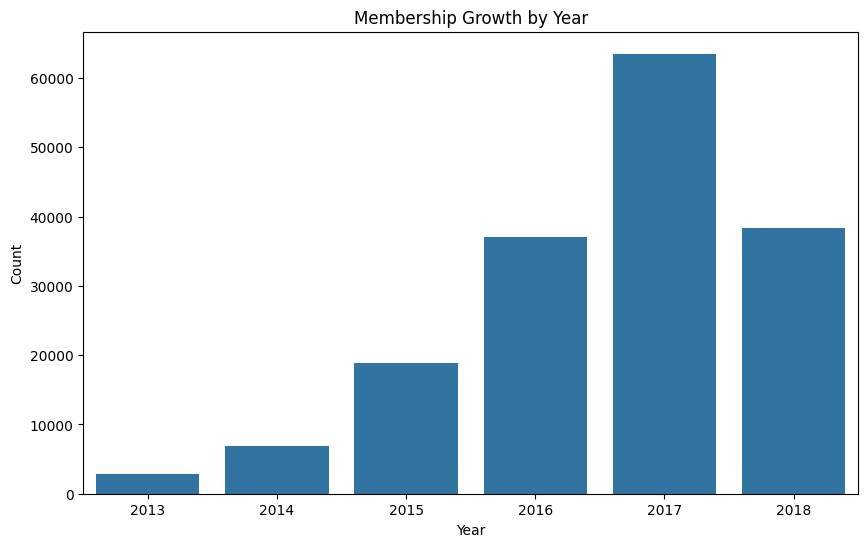

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert 'year' and 'count' columns to numpy arrays
membership_growth['year'] = np.array(membership_growth['year'])
membership_growth['count'] = np.array(membership_growth['count'])

# bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Add trendline using regplot
sns.barplot(x='year', y='count', data=membership_growth, ax=ax)

plt.title('Membership Growth by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [18]:
# factorize id column
offers['id'] = pd.factorize(offers['id'])[0]

offers


,id,event,time,reward,difficulty,duration,offer_type,email,mobile,social,web,gender,age,became_member_on,income,amount,year
0,0,offer_completed,414,5,5,5,bogo,1,1,1,1,M,33,2017-04-21,72000.0,127.60,2017
1,0,offer_completed,528,2,10,10,discount,1,1,1,1,M,33,2017-04-21,72000.0,127.60,2017
2,0,offer_completed,576,2,10,7,discount,1,1,0,1,M,33,2017-04-21,72000.0,127.60,2017
3,0,offer_received,168,0,0,3,informational,1,1,1,0,M,33,2017-04-21,72000.0,127.60,2017
4,0,offer_received,336,0,0,4,informational,1,1,0,1,M,33,2017-04-21,72000.0,127.60,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167576,16993,offer_viewed,174,5,20,10,discount,1,0,0,1,F,45,2016-11-25,62000.0,226.07,2016
167577,16993,offer_viewed,354,2,10,7,discount,1,1,0,1,F,45,2016-11-25,62000.0,226.07,2016
167578,16993,offer_viewed,414,2,10,7,discount,1,1,0,1,F,45,2016-11-25,62000.0,226.07,2016
167579,16993,offer_viewed,534,5,5,7,bogo,1,1,0,1,F,45,2016-11-25,62000.0,226.07,2016


<AxesSubplot:xlabel='year', ylabel='amount'>

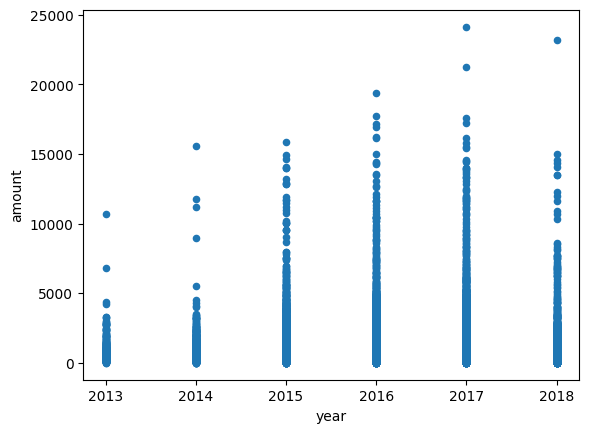

In [19]:
offers.groupby(['id','year'])['amount'].sum().reset_index().plot(x='year', y='amount', kind='scatter')